Alex Albaugh.  Wayne State.  CHE 5995/7507.  Lecture 12.  Winter 2026.

# "In theory, there is no difference between theory and practice. But in practice, there is." -Benjamin Brewster

# Introduction

Artificial neural networks are a predictive model.  They consist of an input layer and an output layer.  In between are hidden layers.  Each hidden layer consists of a number of artificial neurons that "activate" based on their input.  Each connection between neurons has a weight and each neuron also has a bias.  After setting the structure of our neural network, we must train these weights and biases to give our desired output.

Several <code>Python</code> packages are available for efficiently implementing neural networks.  The two most common packages are <code>TensorFlow</code> and <code>PyTorch</code>.  We are going to use a library called <code>Keras</code>, which is built on top of <code>TensorFlow</code>.  <code>Keras</code> will allow us to abstract away some of the more complicated synthax of <code>TensorFlow</code>.  This will allow us to easily construct and train networks, but may come at the cost of advanced features and controls for more complex tasks.

Let's get some data to build a network with.  We'll use Yamil Colón's metal-organic framework data set.  Metal-organic frameworks (MOFs) are crystal structures made from metallic cluster bound with organic linkers into porous 3D structures.  With a large range of metallic and organic components available, there are many possible MOF structures.  MOFs have applications in gas separation and storage.  Here we'll look at about 13,000 different MOFs and we'll build a model to predict their hydrogen storage capacity based on their gravimentric surface area (surface area per mass), volumentric surface area (surface area per volume), void fraction, limiting pore diameter, and largest pore diameter.

The data comes from "Transfer Learning Study of Gas Adsorption in Metal-Organic Frameworks." <url>https://pubs.acs.org/doi/full/10.1021/acsami.0c06858</url>

Let's poke around our data set first.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import sklearn
from tqdm.keras import TqdmCallback

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/albaugh/CHE7507/refs/heads/main/Lecture12/mof_data.csv')

df.head()

,MOF ID,void fraction,Vol. S.A.,Grav. S.A.,Pore diameter Limiting,Pore diameter Largest,H2@100 bar/77K (g/L),H2@100 bar/77K (mol/kg),H2@100 bar/77K (wt%),H2@100 bar/130K (g/L),...,5 bar Selectivity,topology,First nodular symmetry code,First nodular character,First nodular ID,Second nodular symmetry code,Second nodular character,Second nodular ID,Connecting building block ID,Nonsense
0,1,0.69,1763,2215.0,6.2,7.9,47.5,29.8,5.6,30.4,...,6.8,acs,7,metaliic,4,7,metallic,4,10.0,NaN
1,2,0.64,1490,1791.0,8.1,8.8,44.6,26.8,5.1,27.4,...,7.3,acs,7,metaliic,4,7,metallic,4,11.0,NaN
2,3,0.75,2073,2956.0,8.4,9.6,51.6,36.8,6.9,30.3,...,4.9,acs,7,metaliic,4,7,metallic,4,12.0,NaN
3,4,0.76,2096,2850.0,9.5,10.7,49.8,33.8,6.3,27.6,...,3.5,acs,7,metaliic,4,7,metallic,4,13.0,NaN
4,5,0.79,2109,3638.0,9.5,10.9,51.3,44.1,8.1,28.5,...,3.4,acs,7,metaliic,4,7,metallic,4,14.0,NaN


Our features will be the void fraction, volumetric surface area, gravimetric surface area, limiting pore diameter, and largest pore diameter.  Our target will be the hydrogen loading in g/L at 243 K.

In [3]:
X = df[['void fraction','Vol. S.A.','Grav. S.A.','Pore diameter Limiting','Pore diameter Largest']].values
y = df['H2@100 bar/243K (g/L)'].values

Let's visualize our distributions.

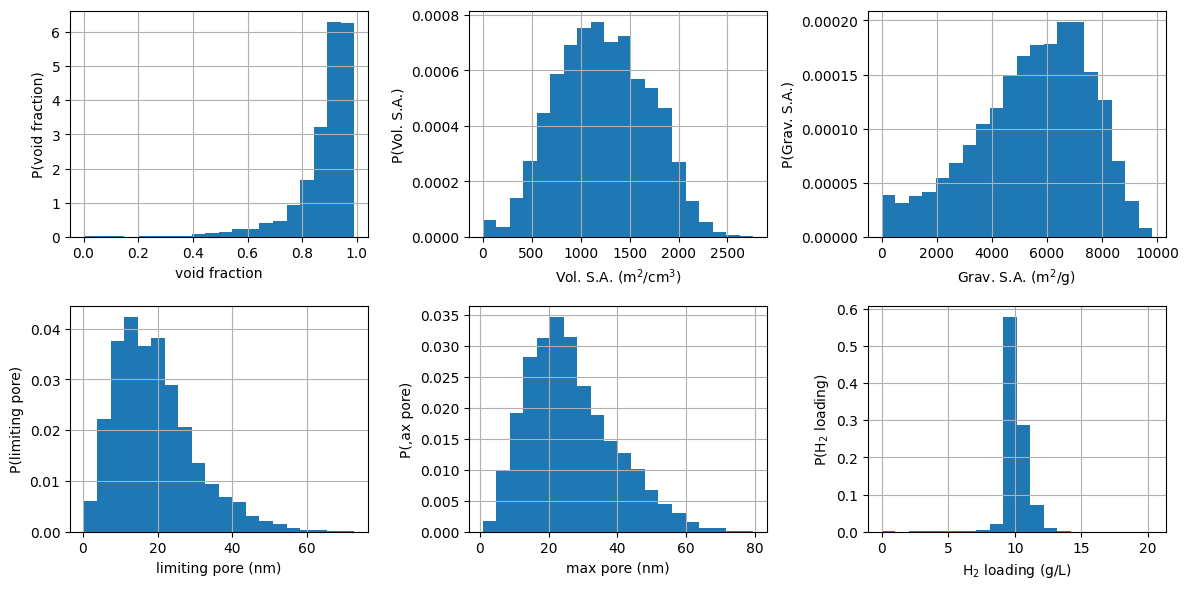

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

axes[0, 0].hist(X[:, 0], bins=20, density=True)
axes[0, 1].hist(X[:, 1], bins=20, density=True)
axes[0, 2].hist(X[:, 2], bins=20, density=True)
axes[1, 0].hist(X[:, 3], bins=20, density=True)
axes[1, 1].hist(X[:, 4], bins=20, density=True)
axes[1, 2].hist(y, bins=20, density=True)

axes[0, 0].set_xlabel('void fraction')
axes[0, 0].set_ylabel('P(void fraction)')
axes[0, 1].set_xlabel('Vol. S.A. (m$^2$/cm$^{3}$)')
axes[0, 1].set_ylabel('P(Vol. S.A.)')
axes[0, 2].set_xlabel('Grav. S.A. (m$^2$/g)')
axes[0, 2].set_ylabel('P(Grav. S.A.)')
axes[1, 0].set_xlabel('limiting pore (nm)')
axes[1, 0].set_ylabel('P(limiting pore)')
axes[1, 1].set_xlabel('max pore (nm)')
axes[1, 1].set_ylabel('P(,ax pore)')
axes[1, 2].set_xlabel('H$_2$ loading (g/L)')
axes[1, 2].set_ylabel('P(H$_2$ loading)')
for ax in axes.flat:
    ax.grid()

plt.tight_layout()
plt.show()

Neural networks perform best with standardized data.  This keeps all of the weights, biases, and gradients of an approximately equivalent size and aids with training.  It's good practice to standardize your features.

In [5]:
scaler = sklearn.preprocessing.StandardScaler()
X = scaler.fit_transform(X)

It's never a bad idea to fit a linear model to get a baseline for comparison.

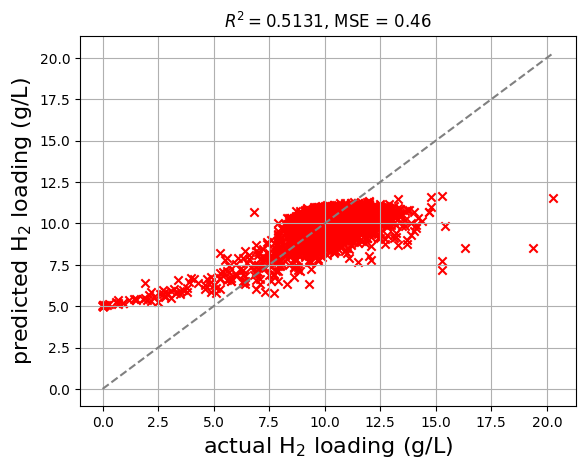

In [6]:
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X, y)

y_pred = linear_model.predict(X)

R2 = sklearn.metrics.r2_score(y, y_pred)

mse = sklearn.metrics.mean_squared_error(y, y_pred)

fig, ax = plt.subplots()
ax.scatter(y, y_pred, color='r', marker='x')
ax.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='gray', linestyle='--')
ax.grid()
ax.set_xlabel('actual H$_2$ loading (g/L)', fontsize=16)
ax.set_ylabel('predicted H$_2$ loading (g/L)', fontsize=16)
ax.set_title('$R^{2}=$'+str(np.round(R2,decimals=4))+', MSE = '+str(np.round(mse,decimals=2)))
plt.show()

# Building and Training Artificial Neural Networks

Here's the basic structure of how to build a neural network with a single hidden layer with 50 neurons.  The hidden layer is called <code>Dense</code> because each of its neurons connects to each neuron in the previous layer and the subsequent layer, making a dense amount of connections.  We'll use a ReLU activation function in our hidden dense layer.  

In [7]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(50, activation='relu'), #our hidden layer as 50 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

We'll now set up our stochastic gradient descent procedure for training the network.  We can define the learning rate here.

In [8]:
sgd = keras.optimizers.SGD(learning_rate=0.002)

At this point we compile the model, combining our network with the optimizer, and we specify our loss function.  Since we're doing a regression task (we're tring to predict a numerical value), mean squared error (MSE) is a good loss function.  At this point we haven't trained the model, but we are set up to do so.

In [9]:
model.compile(optimizer=sgd, loss='mse')

We can see a summary of the model if we want.

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351 (1.37 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

We can now train the network using <code>fit</code>.  Here we'll set the batch size and the number of epochs.  We'll also collect the loss value at each epoch using the <code>history</code> object, which we will analyze later.  Here we'll also set the train procedure to be verbose so we can see what's happening.

In [11]:
history = model.fit(X, y, epochs=10, batch_size=3000, verbose=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 103.9335 
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 92.0675 
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 81.2300 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 70.8457
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 60.8470 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 51.1363
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 41.9364
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 33.4679
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 26.4604
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.5636


Verbose output actually gets pretty annoying, but using this neat <code>callback</code>, we can get a more compact view of our training progess.

In [12]:
history = model.fit(X, y, epochs=1000, batch_size=3000, verbose=0, callbacks=[TqdmCallback()])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Using our saved history, let's see what the training procedure did.  And what our performance looks like.  We'll put this analysis and graphing code in a function because we'll be resuing it frequently.

In [13]:
def graphs_and_analysis(model, history, X, y):
  y_pred = model.predict(X)

  R2 = sklearn.metrics.r2_score(y, y_pred)

  mse = sklearn.metrics.mean_squared_error(y, y_pred)

  fig, ax = plt.subplots()
  ax.scatter(y, y_pred, color='r', marker='x')
  ax.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='gray', linestyle='--')
  ax.grid()
  ax.set_xlabel('actual H$_2$ loading (g/L)', fontsize=16)
  ax.set_ylabel('predicted H$_2$ loading (g/L)', fontsize=16)
  ax.set_title('$R^{2}=$'+str(np.round(R2,decimals=4))+', MSE = '+str(np.round(mse,decimals=2)))

  fig2, ax2 = plt.subplots()
  ax2.plot(history.history['loss'], color='c')
  ax2.grid()
  ax2.set_xlabel('epoch', fontsize=18)
  ax2.set_ylabel('loss (MSE)', fontsize=18)
  ax2.set_yscale('log')
  plt.show()

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step


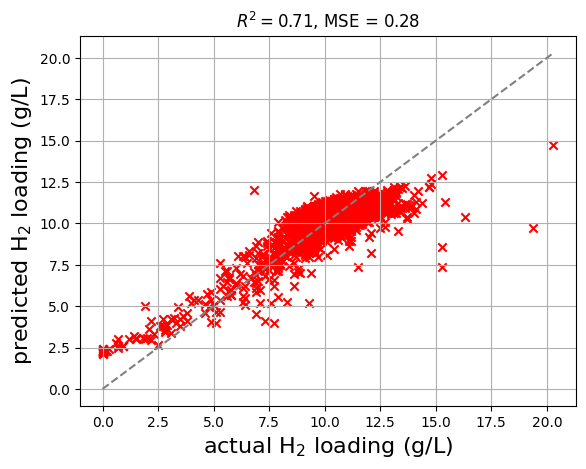

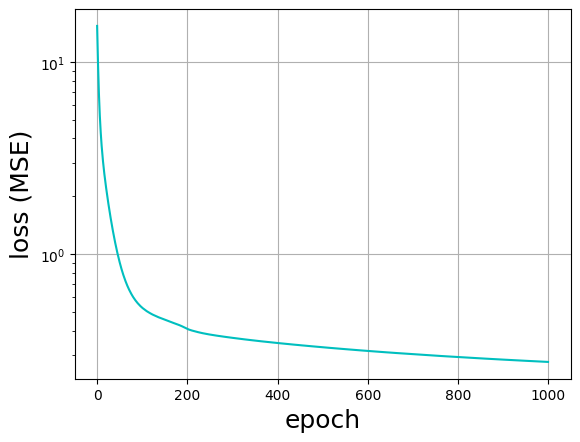

In [14]:
graphs_and_analysis(model, history, X, y)

There are different options available for activation functions.  Above we used the rectified linear unit (ReLU).  We can also choose a logistic function (<code>sigmoid</code>), hyperbolic tangent (<code>tanh</code>), and exponential linear unit (<code>elu</code>), among others.  Here's that same neural network, but using a logistic activation in the hidden layer.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 50)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351 (1.37 KB)

 Trainable params: 351 (1.37 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step


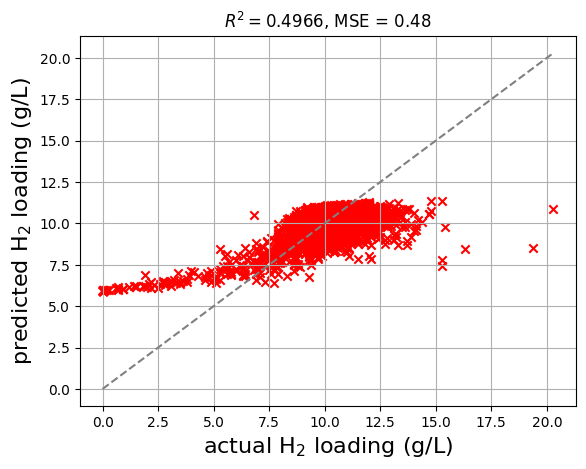

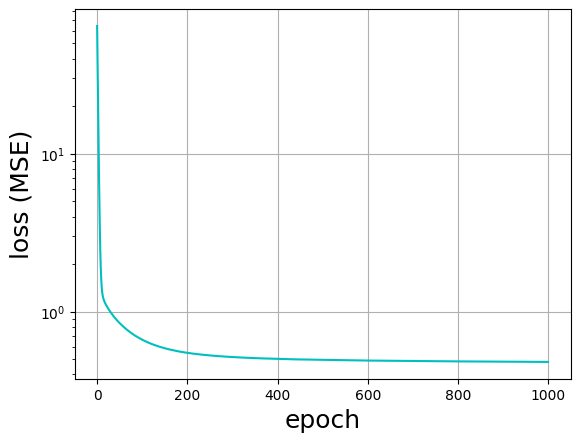

In [15]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(50, activation='sigmoid'), #our hidden layer as 50 neurons and a logistic activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

sgd = keras.optimizers.SGD(learning_rate=0.002)

model.compile(optimizer=sgd, loss='mse')

model.summary()

history = model.fit(X, y, epochs=1000, batch_size=3000, verbose=0, callbacks=[TqdmCallback()])

graphs_and_analysis(model, history, X, y)

Something like leaky ReLU or parametric ReLU (which is like leaky ReLU, but the slope at $x<0$ is also a parameter to be fit), are implemented slightly differenty.  They are implemented as an additional layer after a dense layer without an activation function, as should below.  These can help with the vanishing gradient problem, if you come across it.

In [16]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(50), #create a hidden layer with leaky ReLU by first doing a dense layer without activation...
    keras.layers.LeakyReLU(negative_slope=0.01), #...and then applying the leaky ReLU activation, alpha is the slope for x < 0
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

Let's try a neural network with two hidden layers.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

423/423 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


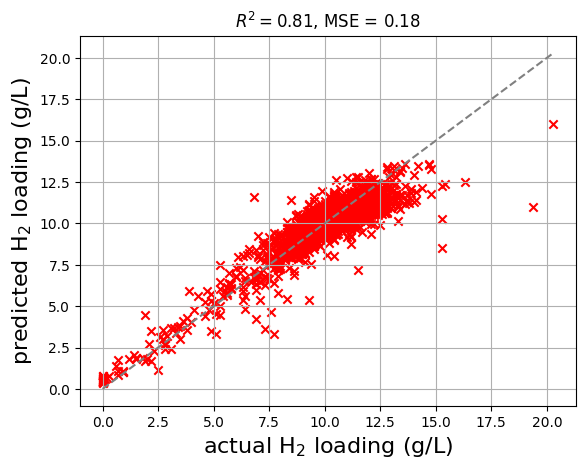

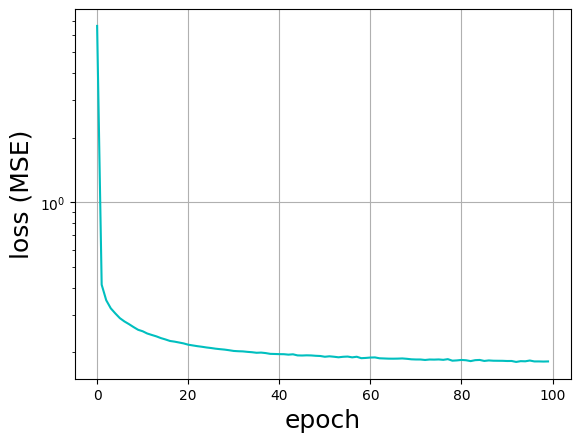

In [17]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu'), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dense(64, activation='relu'), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

sgd = keras.optimizers.SGD(learning_rate=0.002)

model.compile(optimizer=sgd, loss='mse')

model.summary()

history = model.fit(X, y, epochs=100, batch_size=50, verbose=0, callbacks=[TqdmCallback()])

graphs_and_analysis(model, history, X, y)

Another useful tool is the ADAM (adaptive moment estimation) optimizer.  ADAM is based on stochastic gradient descent, but also includes momentum, which is useful for getting out of local minima, and adaptive learning rates, which can make trainng more efficient.

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

423/423 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


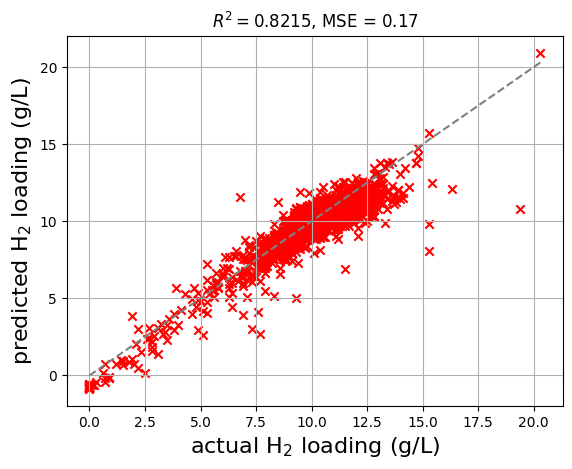

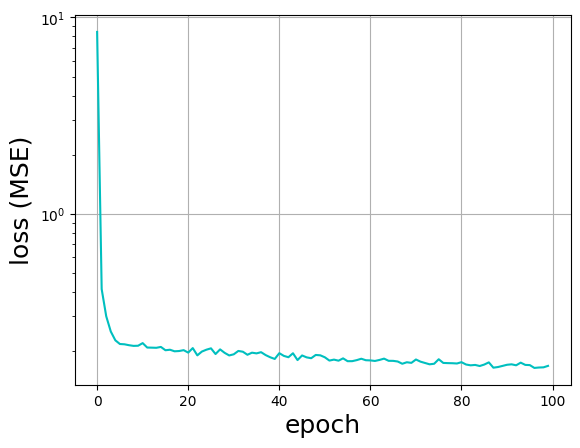

In [18]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu'), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dense(64, activation='relu'), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

adm = keras.optimizers.Adam(learning_rate = 0.002)

model.compile(optimizer=adm, loss='mse')

model.summary()

history = model.fit(X, y, epochs=100, batch_size=50, verbose=0, callbacks=[TqdmCallback()])

graphs_and_analysis(model, history, X, y)

# Validation and Regularization

This particular data set actually fits very well without much overfitting, so to demonstrate validation and regularization, we're going to draw 1,000 samples from it randomly and use this new to demonstrate these methods.  We'll also define a new graphing and analysis function to do validation loss, too.

In [19]:
X_small, y_small = sklearn.utils.resample(X, y, n_samples=1000, random_state=0)

def graphs_and_analysis2(model, history, X, y):
  y_pred = model.predict(X)

  R2 = sklearn.metrics.r2_score(y, y_pred)

  mse = sklearn.metrics.mean_squared_error(y, y_pred)

  fig, ax = plt.subplots()
  ax.scatter(y, y_pred, color='r', marker='x')
  ax.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], color='gray', linestyle='--')
  ax.grid()
  ax.set_xlabel('actual H$_2$ loading (g/L)', fontsize=16)
  ax.set_ylabel('predicted H$_2$ loading (g/L)', fontsize=16)
  ax.set_title('$R^{2}=$'+str(np.round(R2,decimals=4))+', MSE = '+str(np.round(mse,decimals=2)))

  fig2, ax2 = plt.subplots()
  ax2.plot(history.history['mse'], color='c',label='training')
  ax2.plot(history.history['val_mse'], color='pink',label='validation')
  ax2.legend(fontsize=14)
  ax2.grid()
  ax2.set_xlabel('epoch', fontsize=18)
  ax2.set_ylabel('loss (MSE)', fontsize=18)
  ax2.set_yscale('log')
  plt.show()

This is how we can build and train neural networks.  <code>Keras</code> also gives us tools to use for validation and regularization.  Let's use the built-in validation to randomly split our data into a training set and a validation set.  We can track our estimate for the test error throughout the training procedure with the validation set.

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


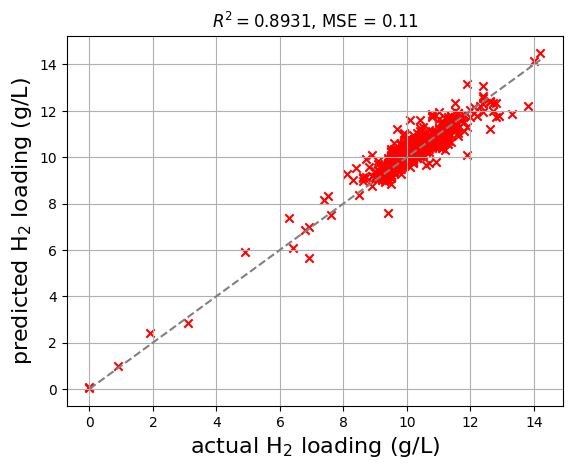

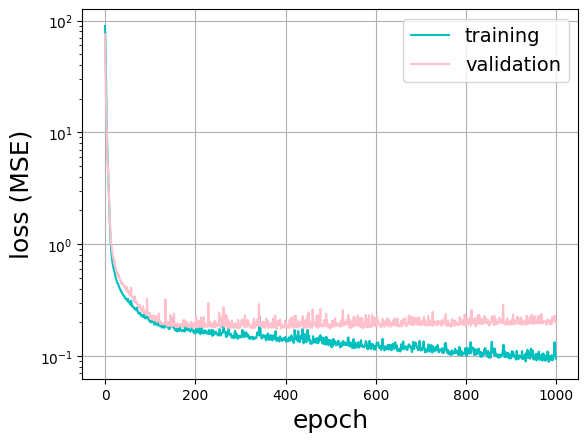

In [20]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu'), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dense(64, activation='relu'), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

adm = keras.optimizers.Adam()

model.compile(optimizer=adm, loss='mse', metrics=['mse'])

model.summary()

history = model.fit(X_small, y_small, epochs=1000, batch_size=50, verbose=0, validation_split=0.2, callbacks=[TqdmCallback()]) #this holds back 20% of the data for validation

graphs_and_analysis2(model, history, X_small, y_small)

Whoa!  Looks like we overfit.  We can prevent this with early stopping.  With early stopping we can decide which metric we use to stop.  We'll want to use validation loss.  With <code>patience</code> we can decide how many consecutive epochs to wait without seeing an improvement.  <code>restore_best_weights=True</code> will reset to the best parameterization before the early stop.

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


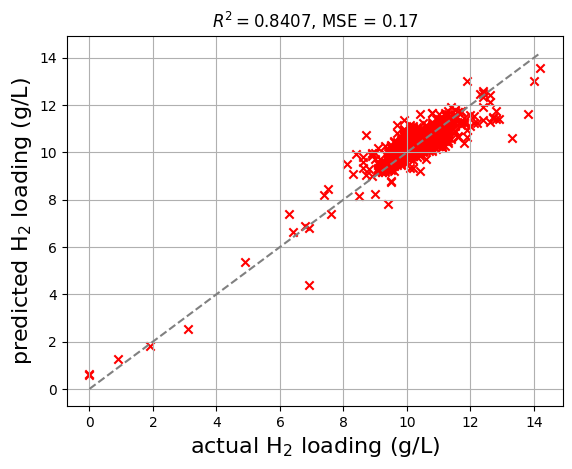

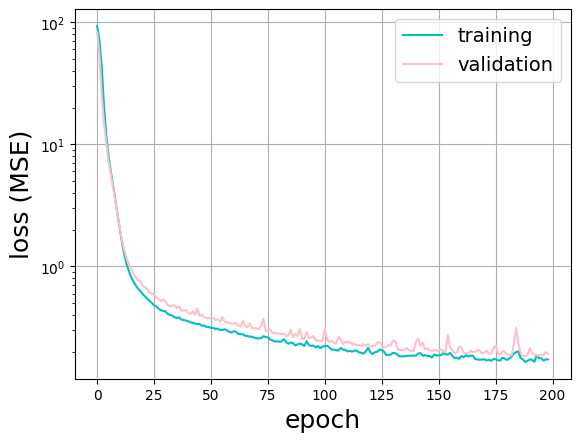

In [21]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu'), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dense(64, activation='relu'), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

adm = keras.optimizers.Adam()

model.compile(optimizer=adm, loss='mse', metrics=['mse'])

model.summary()

early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
#monitor is which metric to track for early stopping
#patience is how many epochs to wait without seeing an improvement before stopping
#restore_best_weights will reset to the model with the best metrics prior to stoppng

history = model.fit(X_small, y_small, epochs=1000, batch_size=50, verbose=0, validation_split=0.2, callbacks=[TqdmCallback(), early_stop]) #this holds back 20% of the data for validation

graphs_and_analysis2(model, history, X_small, y_small)

 Below is a neural network with the same structure as above, but we'll apply $l_2$ (ridge) regularization to the first hidden layer and $l_1$ (LASSO) regularization to the second layer.  These regularization procedures can help overfitting.

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


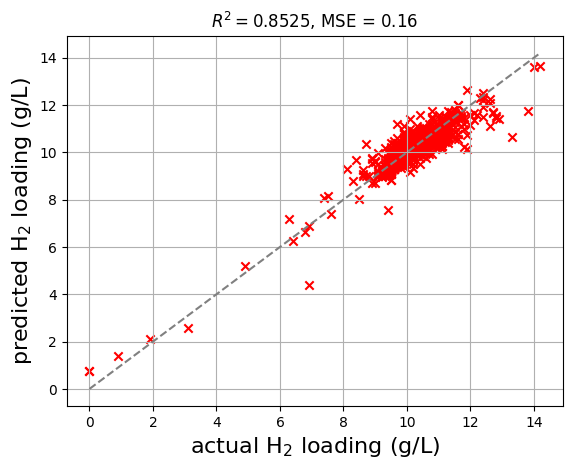

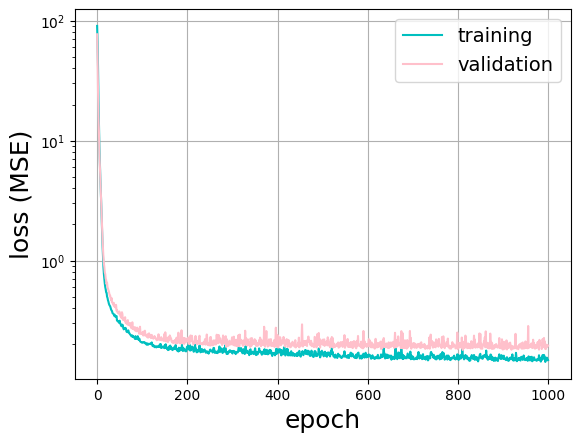

In [22]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l1(0.001)), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

adm = keras.optimizers.Adam()

model.compile(optimizer=adm, loss='mse', metrics=['mse'])

model.summary()

history = model.fit(X_small, y_small, epochs=1000, batch_size=50, verbose=0, validation_split=0.2, callbacks=[TqdmCallback()]) #this holds back 20% of the data for validation

graphs_and_analysis2(model, history, X_small, y_small)

Another form of regularization for neural networks is dropout.  During dropout a random fraction of neurons in a layer have their outputs set to 0 for a training batch.  This effectively removes those neurons from the network during that batch.  In the next batch, a different fraction of the neurons are randomly chosen.  This can make the network more robust as no single neuron can become too important.  We can implement this by using a <code>Dropout</code> layer.  This dropout is automatically applied during training, but not during prediction.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 128)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


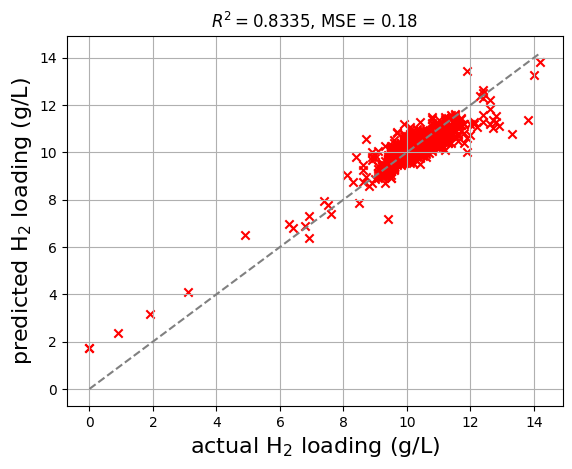

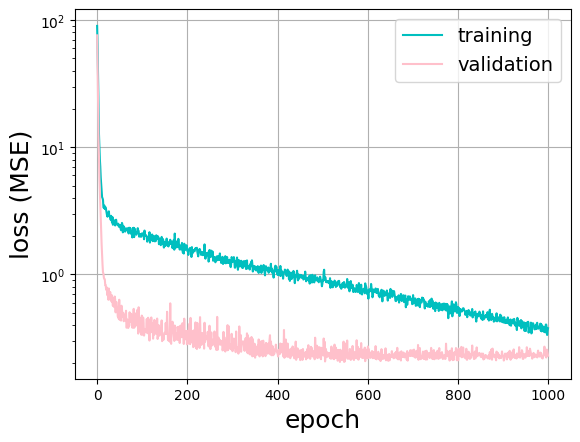

In [23]:
model = keras.Sequential([ #our model is sequential- it starts at the input, moves through hidden layers, and ends with the output
    keras.Input(shape=(5,)), #with our input layer we define the shape of the input, here we have 5 features
    keras.layers.Dense(128, activation='relu'), #our hidden layer as 128 neurons and a ReLU activation
    keras.layers.Dropout(0.4), #here we dropout 40% of the first hidden layer
    keras.layers.Dense(64, activation='relu'), #our hidden layer as 64 neurons and a ReLU activation
    keras.layers.Dropout(0.3), #here we dropout 30% of the second hidden layer
    keras.layers.Dense(1, activation='linear') #our output layer is linear, it takes a linear combinaton of the hidden layer output to return a single value
])

adm = keras.optimizers.Adam()

model.compile(optimizer=adm, loss='mse', metrics=['mse'])

model.summary()

history = model.fit(X_small, y_small, epochs=1000, batch_size=50, verbose=0, validation_split=0.2, callbacks=[TqdmCallback()]) #this holds back 20% of the data for validation

graphs_and_analysis2(model, history, X_small, y_small)